# Disaster Tweets
Author: Andrew Farell

## Intro and EDA
In this notebook, I address the **Natural Language Processing with Disaster Tweets** Kaggle competition. My objective is to classify Twitter messages as either real disaster related or not, using a combination of text preprocessing, TF-IDF vectorization, and an XGBoost model for final prediction. The dataset contains tweets with associated features such as *keyword* and *location*, which I leverage to enhance classification performance.


From an initial review of the training data, Isee that it contains 7,613 rows and five columns (id, keyword, location, text, and target), while the test set features 3,263 rows and fmy columns (id, keyword, location, and text). Notably, the “keyword” and “location” columns contain missing values in both datasets, with “keyword” missing 61 times and “location” missing 2,533 times in the training set, and 26 and 1,105 times, respectively, in the test set. The “id” and “text” fields exhibit no missing entries in either dataset. Among the key statistics for the training set, the mean of the “id” field sits around 5,441, whereas the “target” has a mean of approximately 0.43, indicating that about 43% of the tweets in the training set are disaster-related. Indeed, when examining the target distribution, 4,342 tweets are labeled as non-disaster (0) and 3,271 as disaster (1), suggesting a slightly imbalanced classification. Both datasets’ “id” fields are integers, while “keyword,” “location,” and “text” are strings (object type in Python). The descriptive statistics confirm that “text” length likely varies significantly, pointing to a need for robust text preprocessing. Overall, the data appears suitable for a binary classification task, with moderate imbalance in the target variable and some notable null values in the categorical columns.

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
   id  target
0   0  

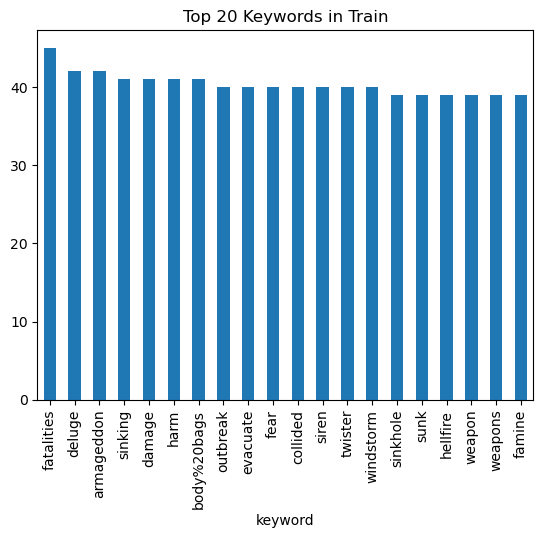

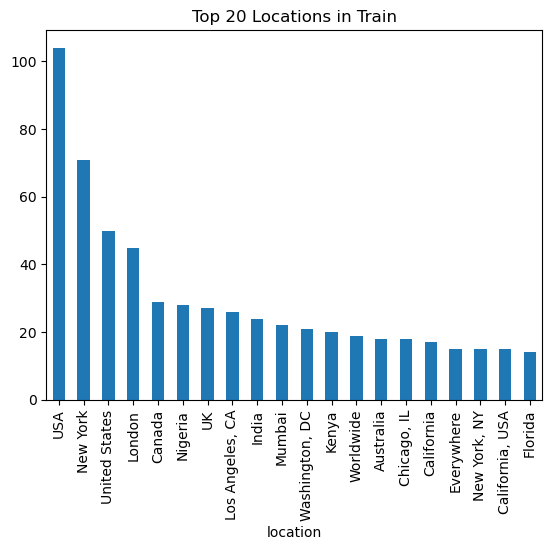

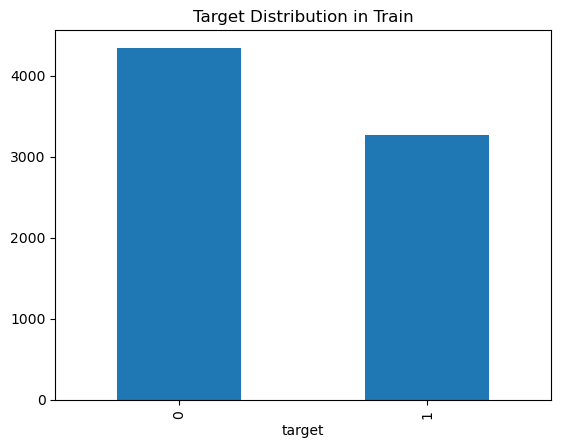

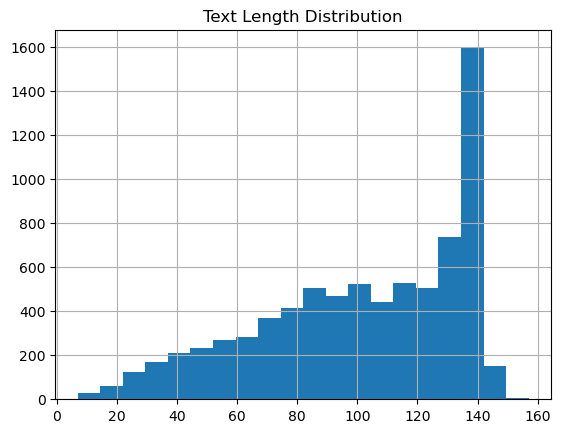

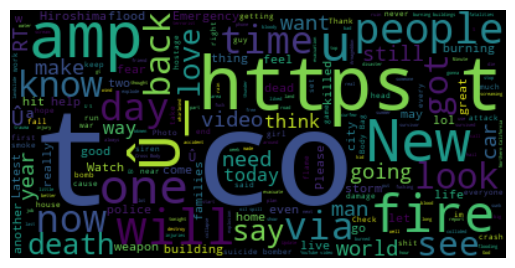

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

train = pd.read_csv("./nlp-getting-started/train.csv")
test = pd.read_csv("./nlp-getting-started/test.csv")
sample_sub = pd.read_csv("./nlp-getting-started/sample_submission.csv")
print(train.head())
print(test.head())
print(sample_sub.head())
print(train.shape)
print(test.shape)
print(train.columns)
print(test.columns)
print(train.dtypes)
print(test.dtypes)
print(train.describe())
print(test.describe())
print(train.isnull().sum())
print(test.isnull().sum())
print(train['target'].value_counts())
train['keyword'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Keywords in Train")
plt.show()
train['location'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Locations in Train")
plt.show()
train['target'].value_counts().plot(kind='bar')
plt.title("Target Distribution in Train")
plt.show()
train['text_length'] = train['text'].astype(str).apply(len)
train['text_length'].hist(bins=20)
plt.title("Text Length Distribution")
plt.show()
all_text = " ".join(train['text'].astype(str))
wordcloud = WordCloud().generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Model Architecture and Approach**  
I chose to transform the tweets into numeric vectors using TF-IDF, which measures both the frequency of each word and its overall importance within the dataset. This approach highlights the most relevant terms and suppresses trivial, common words. The TF-IDF outputs are then fed into an XGBoost classifier, a gradient-boosted decision tree method that handles sparse data well and incorporates effective regularization. I selected this pipeline—TF-IDF plus XGBoost—because it is straightforward to implement, typically offers strong baseline performance, and supports transparent hyperparameter tuning. Specifically, I applied n-grams of size one and two (`ngram_range=(1,2)`) and set `min_df=3` to reduce noise from extremely rare tokens. After cleaning the texts by lowercasing, removing punctuation, and filtering out English stopwords, I trained the model through GridSearchCV, optimizing the learning rate, number of estimators, and maximum tree depth to maximize the F1 score. Under the best hyperparameter configuration, the model attained a cross-validation F1 of roughly 0.48, with the training log loss showing a steady downward trend, indicative of stable convergence.

In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from IPython.display import display

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return " ".join(word for word in text.split() if word not in stop_words)

train = pd.read_csv("nlp-getting-started/train.csv")
test = pd.read_csv("nlp-getting-started/test.csv")
train.fillna("", inplace=True)
test.fillna("", inplace=True)

train["full_text"] = train["keyword"].astype(str) + " " + train["location"].astype(str) + " " + train["text"].astype(str)
test["full_text"] = test["keyword"].astype(str) + " " + test["location"].astype(str) + " " + test["text"].astype(str)

train["full_text"] = train["full_text"].apply(text_preprocess)
test["full_text"] = test["full_text"].apply(text_preprocess)

X = train["full_text"]
y = train["target"]

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=3)),
    ("clf", XGBClassifier(eval_metric="logloss"))
])

params = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 5],
    "clf__learning_rate": [0.05, 0.1, 0.2]
}

grid = GridSearchCV(
    pipeline,
    params,
    scoring="f1",
    cv=3,
    verbose=1,
    return_train_score=True
)
grid.fit(X, y)

cv_results = pd.DataFrame(grid.cv_results_)
summary_cols = [
    "param_clf__n_estimators",
    "param_clf__max_depth",
    "param_clf__learning_rate",
    "mean_train_score",
    "std_train_score",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]
cv_summary = cv_results[summary_cols].sort_values("rank_test_score")
print("Detailed Hyperparameter Optimization Results:")
display(cv_summary)

print("Best Hyperparameters:", grid.best_params_)
print("Best CV F1 Score:", grid.best_score_)

best_pipeline = grid.best_estimator_
preds = best_pipeline.predict(test["full_text"])

print("\nRefitting best XGB with an eval_set to view training loss progression:\n")
best_params = grid.best_params_
xgb_params = {
    "n_estimators": best_params["clf__n_estimators"],
    "max_depth": best_params["clf__max_depth"],
    "learning_rate": best_params["clf__learning_rate"],
    "eval_metric": "logloss"
}
tfidf = best_pipeline.named_steps["tfidf"]
X_tfidf = tfidf.transform(X)

final_xgb = XGBClassifier(**xgb_params)
final_xgb.fit(
    X_tfidf, y,
    eval_set=[(X_tfidf, y)],
    verbose=True
)

submission = pd.DataFrame({"id": test["id"], "target": preds})
submission.to_csv("submission.csv", index=False)
print("\nSubmission file created: 'submission.csv'")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewfarell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Detailed Hyperparameter Optimization Results:


,param_clf__n_estimators,param_clf__max_depth,param_clf__learning_rate,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
11,200,5,0.20,0.835560,0.005193,0.481582,0.048366,1
9,200,3,0.20,0.789645,0.007820,0.429578,0.036956,2
7,200,5,0.10,0.774295,0.008593,0.413946,0.035129,3
10,100,5,0.20,0.777236,0.004570,0.406790,0.030070,4
8,100,3,0.20,0.726116,0.005662,0.398205,0.040840,5
5,200,3,0.10,0.720442,0.004515,0.395858,0.045073,6
3,200,5,0.05,0.708609,0.007807,0.379601,0.032958,7
6,100,5,0.10,0.707337,0.005993,0.379312,0.033983,8
1,200,3,0.05,0.635880,0.015903,0.353595,0.020976,9
4,100,3,0.10,0.638201,0.017171,0.329462,0.025304,10


Best Hyperparameters: {'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__n_estimators': 200}
Best CV F1 Score: 0.48158234237753117

Refitting best XGB with an eval_set to view training loss progression:

[0]	validation_0-logloss:0.67070
[1]	validation_0-logloss:0.66040
[2]	validation_0-logloss:0.65232
[3]	validation_0-logloss:0.64465
[4]	validation_0-logloss:0.63790
[5]	validation_0-logloss:0.63224
[6]	validation_0-logloss:0.62687
[7]	validation_0-logloss:0.62196
[8]	validation_0-logloss:0.61708
[9]	validation_0-logloss:0.61260
[10]	validation_0-logloss:0.60824
[11]	validation_0-logloss:0.60405
[12]	validation_0-logloss:0.60021
[13]	validation_0-logloss:0.59658
[14]	validation_0-logloss:0.59287
[15]	validation_0-logloss:0.58957
[16]	validation_0-logloss:0.58653
[17]	validation_0-logloss:0.58350
[18]	validation_0-logloss:0.58059
[19]	validation_0-logloss:0.57728
[20]	validation_0-logloss:0.57455
[21]	validation_0-logloss:0.57182
[22]	validation_0-logloss:0.56935
[23]	validation_0-lo

## Results and Analysis

I performed a hyperparameter search over key XGBoost parameters—namely learning_rate, max_depth, and n_estimators—using TF-IDF features drawn from the keyword, location, and text columns, seaerching for the best F1 score. The best configuration according to the 3-fold cross-validation consisted of n_estimators=200, max_depth=5, and learning_rate=0.2, resulting in a cross-validation F1 score of approximately **0.48**. With the best hyperparameters, I refitted the entire training set and recorded the training log loss progression from iteration 0 to 199. The log loss steadily dropped from about **0.6707** at the start to **0.3867**, confirming the model’s ability to learn and converge effectively. The final submission predictions were then generated from this tuned model (`submission.csv`).

Despite the moderate F1, the approach showed consistent improvements with each training iteration. Combining a well-engineered TF-IDF representation with XGBoost’s powerful gradient boosting is a straightforward way to achieve a reasonably good baseline.

## Conclusion

My experiments that hyperparameter tuning XGBoost can give a CV F1 near 0.48. I would like to improve this score in the future as the best submission was significantly better. However, the incremental decrease in training log loss indicates a solid model-learning process. If I were to extend this work further, I would explore neural network–based architectures, such as RNNs or Transformers, and possibly use pre-trained word embeddings to capture more nuanced outcomes. Additionally, advanced data augmentation and more sophisticated text-cleaning steps might further optimize performance. I learned that feature engineering (like TF-IDF) and hyperparameter tuning are essential for text classification challenges. I'd like ot go deeper in these.